# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

### For Google Colab only:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Deep Learning

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import array, hstack
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from lists import list_str, datafiles, datafiles_1k, datafiles_google

tf.version.VERSION

'2.3.0'

In [2]:
# Load data
data = [None]*len(list_str)
for i in range(len(list_str)):
    data[i] = np.load(datafiles[i])
    #data_raw[i] = np.load(datafiles_google[i])

# Data preperation for keras
data = np.array(data, dtype = "float32")
data.shape

(69, 30000)

### Multivariate

Sampling rate: 100
(297, 300, 2) (297, 100, 2)


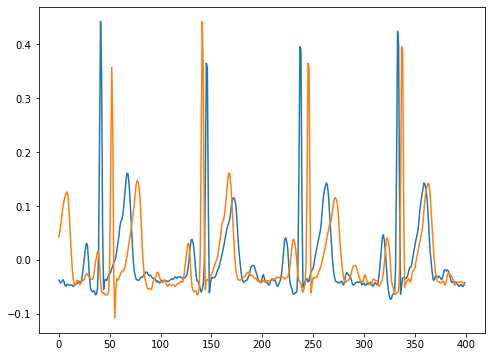

In [3]:
# Setting sampling rate
sampling_rate = 100
print("Sampling rate:", sampling_rate)

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        ''' Warning: may overlap between participants when i < Hz (?) + randomization??? '''
        if i % (sampling_rate) == 0: # to reduce redundancy in ECG-data ## maybe even == sampling_rate to completely *remove* redundancy?
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the dataset
            if out_end_ix > len(sequences):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

# define input sequence
''' only for dyads'''
in_seq1 = data[0]
in_seq2 = data[16]
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2))
# choose a number of time steps
n_steps_in, n_steps_out = 3*sampling_rate, 1*sampling_rate
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)

# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])
# the dataset knows the number of features, e.g. 2

n_features = X.shape[2]

test = np.append(X[3,:,0], y[3,:,0])
test2 = np.append(X[2,:,0], y[2,:,0])
plt.plot(test)
plt.plot(test2)

In [4]:
# Data split
print(X.shape,y.shape)

num_train_samples = int(0.5 * len(X))
num_val_samples = int(0.25 * len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]
X_vali = X[num_train_samples:(num_train_samples+num_val_samples)]
y_vali = y[num_train_samples:(num_train_samples+num_val_samples)]
X_test = X[(num_train_samples+num_val_samples):]
y_test = y[(num_train_samples+num_val_samples):]

print(len(X_train), len(X_vali), len(X_test))

(297, 300, 2) (297, 100, 2)
num_train_samples: 148
num_val_samples: 74
num_test_samples: 75
148 74 75


In [26]:
# define model
model = Sequential()
model.add(LSTM(900, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(400, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

In [27]:
# fit model
history = model.fit(X_train, y_train, epochs=256, batch_size=32, verbose=1, validation_data=(X_vali, y_vali))

Epoch 1/256
5/5 [==============================] - 29s 5s/step - loss: 0.0063 - mae: 0.0517 - val_loss: 0.0064 - val_mae: 0.0527
Epoch 2/256
5/5 [==============================] - 27s 5s/step - loss: 0.0063 - mae: 0.0514 - val_loss: 0.0064 - val_mae: 0.0518
Epoch 3/256
5/5 [==============================] - 27s 5s/step - loss: 0.0063 - mae: 0.0516 - val_loss: 0.0064 - val_mae: 0.0525
Epoch 4/256
5/5 [==============================] - 25s 5s/step - loss: 0.0063 - mae: 0.0516 - val_loss: 0.0064 - val_mae: 0.0519
Epoch 5/256
5/5 [==============================] - 25s 5s/step - loss: 0.0063 - mae: 0.0515 - val_loss: 0.0064 - val_mae: 0.0521
Epoch 6/256
5/5 [==============================] - 26s 5s/step - loss: 0.0063 - mae: 0.0516 - val_loss: 0.0064 - val_mae: 0.0521
Epoch 7/256
5/5 [==============================] - 25s 5s/step - loss: 0.0063 - mae: 0.0515 - val_loss: 0.0064 - val_mae: 0.0522
Epoch 8/256
5/5 [==============================] - 26s 5s/step - loss: 0.0063 - mae: 0.0516 - val

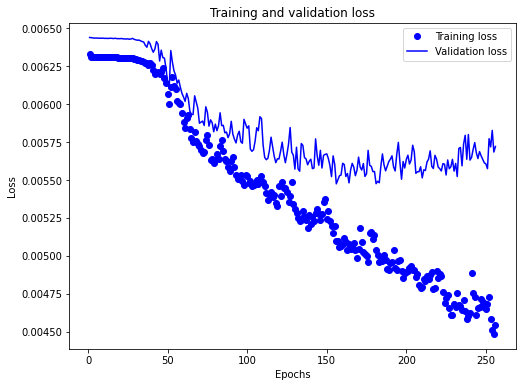

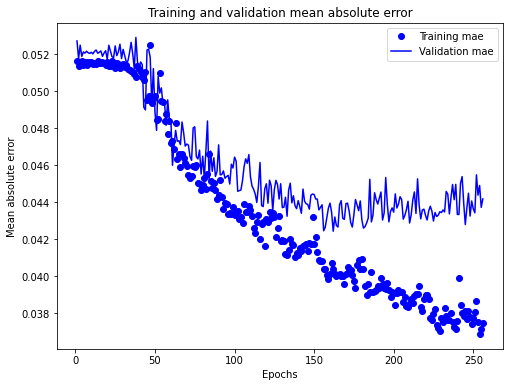

In [28]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
mae = history_dict["mae"]
val_mae = history_dict["val_mae"]
plt.plot(epochs, mae, "bo", label="Training mae")
plt.plot(epochs, val_mae, "b", label="Validation mae")
plt.title("Training and validation mean absolute error")
plt.xlabel("Epochs")
plt.ylabel("Mean absolute error")
plt.legend()
plt.show()

(300, 2)


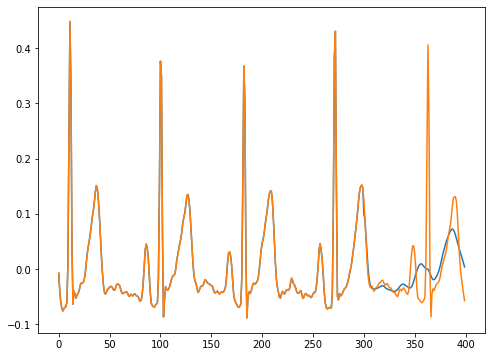

In [29]:
# model demonstration

trial = 10

#print(X_test[1,:,:])
print(X_test[1].shape)

# demonstrate training
yhat = model.predict(X_train,batch_size=10)

trial = 8
test = np.append(X_train[trial],yhat[trial])
test2 = np.append(X_train[trial],y_train[trial])

plt.plot(test)
plt.plot(test2)

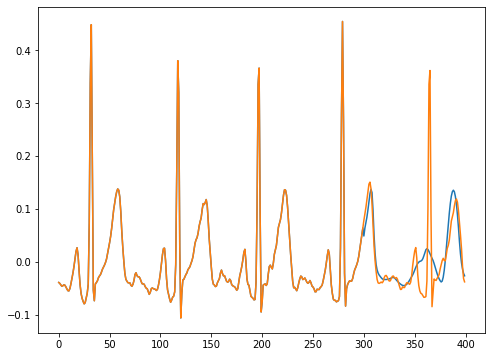

In [31]:
# demonstrate prediction
yhat = model.predict(X_test,batch_size=10)

trial = 7
person = 0
test = np.append(X_test[trial,:,person],yhat[trial,:,person])
test2 = np.append(X_test[trial,:,person],y_test[trial,:,person])

plt.plot(test)
plt.plot(test2)

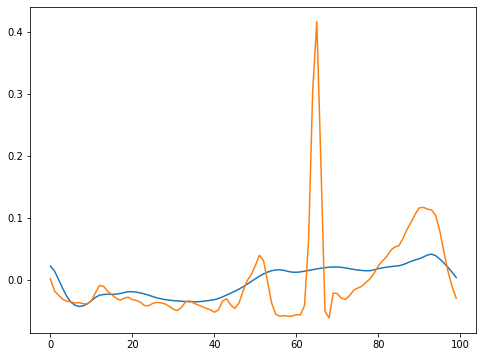

In [32]:

yhat.shape
plt.plot(yhat[2,:,0])
plt.plot(y_test[2,:,0])